<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [4]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import math
from time import time

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from phik import phik_matrix
import plotly.figure_factory as ff

import category_encoders as ce
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,StandardScaler,MinMaxScaler,RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [5]:
taxi =  pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
print(taxi.head())
taxi.info()

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


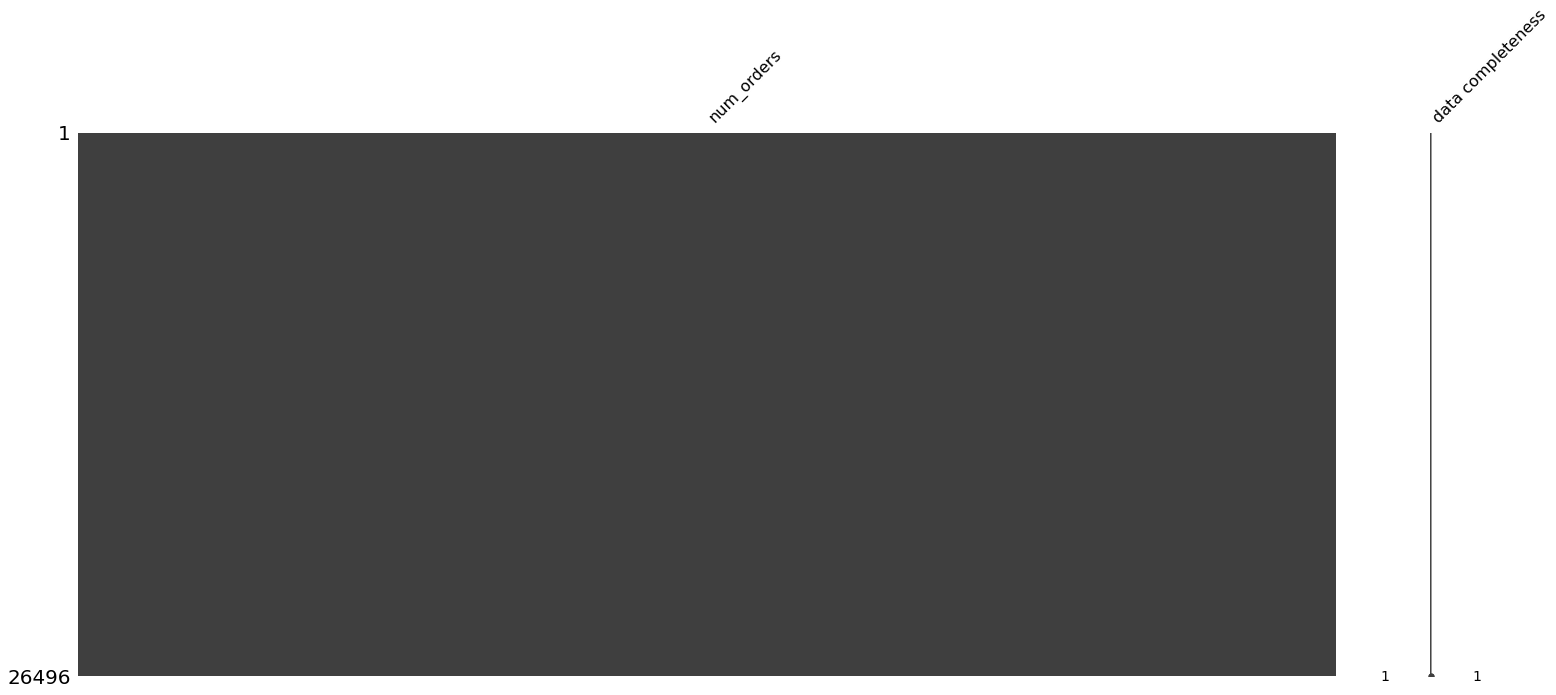

In [6]:
msno.matrix(taxi, labels=True)
plt.show()

Пропусков в данных нет

In [7]:
taxi = taxi.resample('1H').sum()

## Анализ

In [8]:
def p(data,title):
    data.plot()
    plt.title(title)
    plt.figure(figsize=(20, 4))
    plt.show()

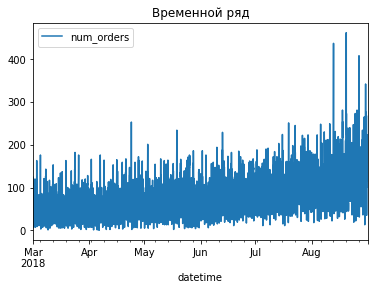

<Figure size 1440x288 with 0 Axes>

In [9]:
p(taxi,'Временной ряд')

Пока из этого графика мало, что можно понять. Следует декомпозировать данные.

In [10]:
decomposed = seasonal_decompose(taxi)

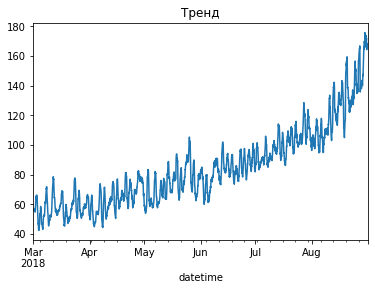

<Figure size 1440x288 with 0 Axes>

In [11]:
p(decomposed.trend, 'Тренд')

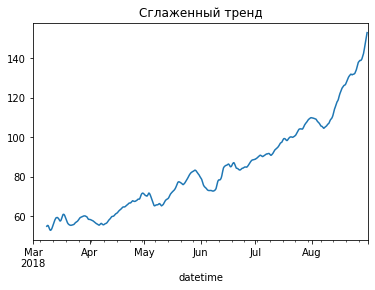

<Figure size 1440x288 with 0 Axes>

In [12]:
p(decomposed.trend.rolling(24*7).mean(), 'Сглаженный тренд')

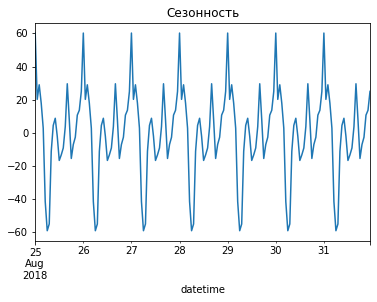

<Figure size 1440x288 with 0 Axes>

In [13]:
p(decomposed.seasonal.tail(24*7), 'Сезонность')

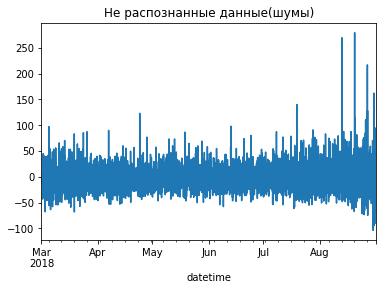

<Figure size 1440x288 with 0 Axes>

In [14]:
p(decomposed.resid, 'Не распознанные данные(шумы)')

Графики показывают тренд роста заказов. В августе произошел сильный скачек вверх. В шумах видно большее количество данных в конце датафрейма из за этого метрика на тестовых данных может постарадать.

In [15]:
taxi_day = taxi.resample('1D').sum()
decomposed_day = seasonal_decompose(taxi_day)

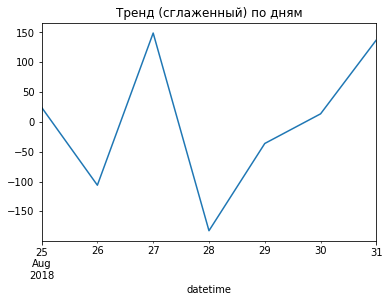

<Figure size 1440x288 with 0 Axes>

In [16]:
p(decomposed_day.seasonal.tail(7), 'Тренд (сглаженный) по дням')

В последнюю неделю наблюдается спад воскресенье(25 число), подъем в понедельник(27 число), спад во вторник(28 число) и стабильный подъем вплоть до пятницы

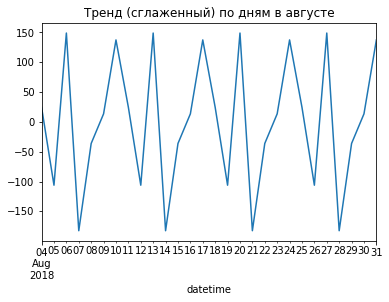

<Figure size 1440x288 with 0 Axes>

In [17]:
p(decomposed_day.seasonal.tail(4*7), 'Тренд (сглаженный) по дням в августе')

Такая же сезонность наблюдается на протяжении всего августа

## Обучение

In [18]:
taxi['weekday'] = taxi.index.weekday
taxi['hour'] = taxi.index.hour
    
for lag in range(1, 24):
    taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
    
taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(24).mean()
taxi.dropna(inplace=True)

Создал признаки дней и часов для предсказания на основе суточной сезонности.

In [19]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

Создал метрику для оценки качества моделей

In [20]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

X = taxi.drop('num_orders', axis=1)
y = taxi['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,shuffle=False
)
tscv = TimeSeriesSplit(n_splits=5)

In [21]:
num_columns = ['weekday', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
               'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 
               'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 
               'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 
               'lag_21', 'lag_22', 'lag_23', 'rolling_mean']

preprocessing = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
    steps=[
        ('preprocessor', preprocessing),
        ('model', LinearRegression())
    ]
)

grid_1 = GridSearchCV(
    estimator=pipe_final,
    param_grid={},
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=-1
)

grid_1.fit(X_train, y_train)

print('Лучшая модель и ее параметры:', grid_1.best_estimator_, '\nRMSE:', -grid_1.best_score_)

Лучшая модель и ее параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['weekday', 'hour', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
                                                   'lag_23',
                                                   'rolling_mean'])])),
                ('model', Linea

In [22]:
params_other = [
    {
        'learning_rate':  [0.1, 0.25], 
        'max_depth': [3,5, 10],
    }
]

lgb_grid = GridSearchCV(
    lgb.LGBMRegressor(random_state=RANDOM_STATE, reg_lambda=0.1),
    param_grid=params_other, 
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs= 1,
    verbose=2
)

lgb_grid.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', lgb_grid.best_estimator_,'\nRMSE:',lgb_grid.best_score_*-1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.4s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.3s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.3s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.9s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.4s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.3s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   1.2s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.8s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   1.1s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   1.2s
[CV] END ....................learning_rate=0.1, max_depth=10; total time=   0.8s
[CV] END ....................learning_rate=0.1, m

In [23]:
params_other = [
    {
        'max_depth': range(3, 5),
        'min_samples_split': range(5, 10),
        'min_samples_leaf': range(5, 10),
    }
]

des_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid=params_other, 
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=2
)

des_grid.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', des_grid.best_estimator_,'\nRMSE:',des_grid.best_score_*-1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV] END max_depth=3, min_samples_le

In [24]:
params_other = [
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10],
    }
]

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=12345),
    param_grid=params_other, 
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', rf_grid.best_estimator_,'\nRMSE:',rf_grid.best_score_*-1)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=1, min_samples_leaf=1, m

In [25]:
params_other = [
    {
        'learning_rate': [0.01, 0.1, 0.2],
        'iterations': [100, 300, 600],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    }
]

cat_grid = GridSearchCV(
    CatBoostRegressor(random_seed=12345, verbose=0),
    param_grid=params_other, 
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=1,
    verbose=2
)

cat_grid.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', cat_grid.best_estimator_,'\nRMSE:',cat_grid.best_score_*-1)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.9s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.9s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.1s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.0s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.3s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   1.3s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   1.0s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   1.1s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   1.0s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   1.1s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.2; total time=   0.9s
[CV] END ...iterations=100, l2_leaf_reg=1, lear

In [26]:
print('LinearRegression RMSE:',grid_1.best_score_*-1)
print('LGBMRegressor RMSE:',lgb_grid.best_score_*-1)
print('DecisionTreeRegressor RMSE:',des_grid.best_score_*-1)
print('RandomForestRegressor RMSE:',rf_grid.best_score_*-1)
print('CatBoostRegressor RMSE:',cat_grid.best_score_*-1)

LinearRegression RMSE: 27.138358984439048
LGBMRegressor RMSE: 24.959139131922925
DecisionTreeRegressor RMSE: 30.814912696858734
RandomForestRegressor RMSE: 25.8275411555481
CatBoostRegressor RMSE: 24.74854420609054


Лучшей моделью оказался CatBoostRegressor

## Тестирование

In [27]:
pred=cat_grid.best_estimator_.predict(X_test)
rmse_ = rmse(y_test,pred)
rmse_

42.07770795268382

## Вывод

Результат анализа показал, что наблюдается восходящий тренд с весны по осень. 
В ходе работы сеплировал данные по часам. На этих данных были обучены несколько моделей:LinearRegression,LGBMRegressor,DecisionTreeRegressor,RandomForestRegressor,CatBoostRegressor. 
Лучшей оказалось CatBoostRegressor c метрикой 25 на тренировочных и тестовых данных.